# 🐾 AnimalCLEF2025 Competition: Official Starter notebook

The **Goal of the** [AnimalCLEF2025](https://www.kaggle.com/competitions/animal-clef-2025/) competition is to identify individual animal (lynxes, salamanders and sea turtles) in photos. This notebook visualize the provided dataset and propose a baseline solution, based on the state-of-the-art re-identification model [MegaDescriptor](https://huggingface.co/BVRA/MegaDescriptor-L-384). The dataset is split into the database and query sets. For each image from the query set, the goal is to:

- Predict whether the depicted individual is in the database.
- If no, the prediction is `new_individual`.
- If yes, the prediction should be the same as the individual in the database.

## Dependencies instalation
For the competition we provide two Python packages for loading and preprocessing of available datasets ([wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets)) and tools / method for animal re-identification ([wildlife-tools](https://github.com/WildlifeDatasets/wildlife-tools)).

## Dependencies import
We load all the required packages and then define the function `create_sample_submission`, which converts provided predictions and a submission file for the competition.

In [21]:
import os
import numpy as np
import pandas as pd
import timm
import torchvision.transforms as T
from wildlife_datasets.datasets import AnimalCLEF2025
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
def create_sample_submission(dataset_query, predictions, file_name='sample_submission.csv'):
    df = pd.DataFrame({
        'image_id': dataset_query.metadata['image_id'],
        'identity': predictions
    })
    df.to_csv(file_name, index=False)

We need to specify the `root`, where the data are stored and then two image transformations. 
1. The first transform only resizes the images and is used for visualization.
2. The second transform also converts it to torch tensor and is used for operations on neural networks.

In [22]:
root = '.'
transform_display = T.Compose([
    # T.Resize([384, 384]),
    T.Resize([224, 224]),
    ])
transform = T.Compose([
    *transform_display.transforms,
    T.ToTensor(),
    T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])

### 📊 Visualizing Data

Since `AnimalCLEF2015` is the child class of `datasets.WildlifeDataset` from [wildlife-datasets](https://github.com/WildlifeDatasets/wildlife-datasets/blob/main/wildlife_datasets/datasets/datasets.py), it inherits all its methods and attributes. The following code specify which `transform` we want to use while loading images and that we want to load labels alongside images.

In [23]:
dataset = AnimalCLEF2025(root, transform=transform_display, load_label=True)

📌 **Plotting a sample grid** of the data. We can see that all animals in the testing sets are turtles. The column `dataset` states that all the photos come from the SeaTurtleID2022 dataset.

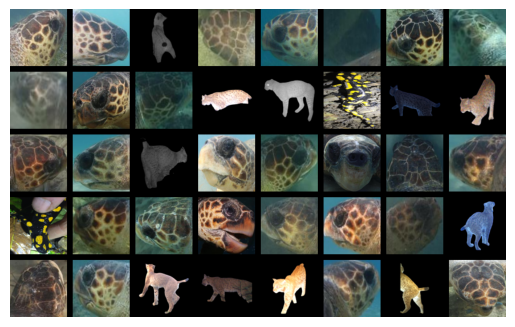

In [24]:
dataset.plot_grid()
dataset.metadata
dataset.metadata['species'] = dataset.metadata['species'].fillna('salamandra')

In [25]:
dataset.metadata['species'] = dataset.metadata['species'].fillna('salamander')

This is confirmed by showing all datasets from which the data is composed of.

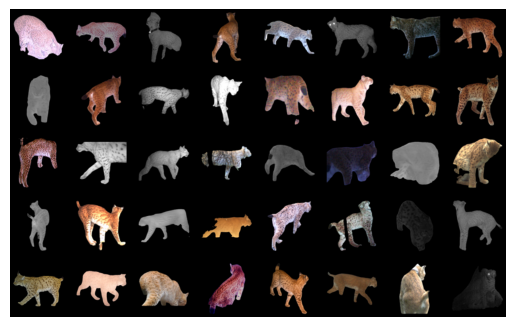

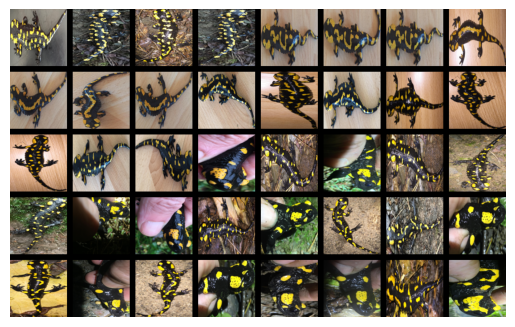

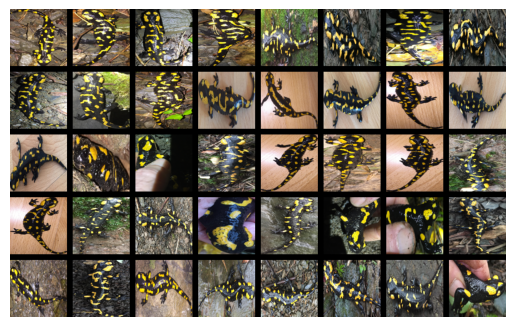

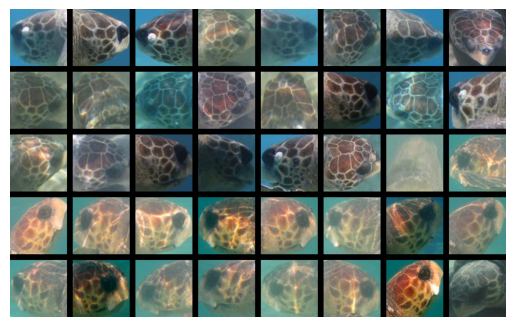

In [26]:
for species in dataset.metadata['species'].unique():
    idx = dataset.metadata['species'].str.contains(species)
    idx[idx.isnull()] = False
    dataset.plot_grid(idx=idx)

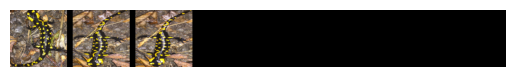

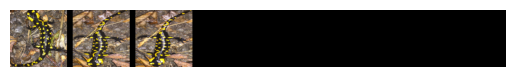

In [30]:
identity = 'SalamanderID2025_74'
idx = dataset.metadata['identity'] == identity
idx[idx.isnull()] = False
dataset.plot_grid(idx=idx)

In [7]:
# Loading the dataset
import matplotlib.pyplot as plt
dataset = AnimalCLEF2025(root, transform=transform, load_label=True)
dataset.metadata['species'] = dataset.metadata['species'].fillna('salamander')
dataset_database = dataset.get_subset(dataset.metadata['split'] == 'database')
dataset_query = dataset.get_subset(dataset.metadata['split'] == 'query')
n_data = len(dataset_database)
n_query = len(dataset_query)
print(f"Number of database images: {n_data}, number of query images: {n_query}")
print(f"Number of unknown species: {dataset.metadata['species'].isna().sum()}")
print(dataset_database.metadata.groupby('species').count())
print(dataset_query.metadata.groupby('species').count())

Number of database images: 13074, number of query images: 2135
Number of unknown species: 0
                   image_id  identity  path  date  orientation  split  dataset
species                                                                       
loggerhead turtle      8729      8729  8729  8729         8526   8729     8729
lynx                   2957      2957  2957     0         2957   2957     2957
salamander             1388      1388  1388  1384         1388   1388     1388
                   image_id  identity  path  date  orientation  split  dataset
species                                                                       
loggerhead turtle       500         0   500   500            0    500      500
lynx                    946         0   946     0          946    946      946
salamander              689         0   689   689          689    689      689


Number of individuals in database: 1102
Number of individuals for lynx: 77
Number of individuals for salamander: 587
Number of individuals for loggerhead turtle: 438


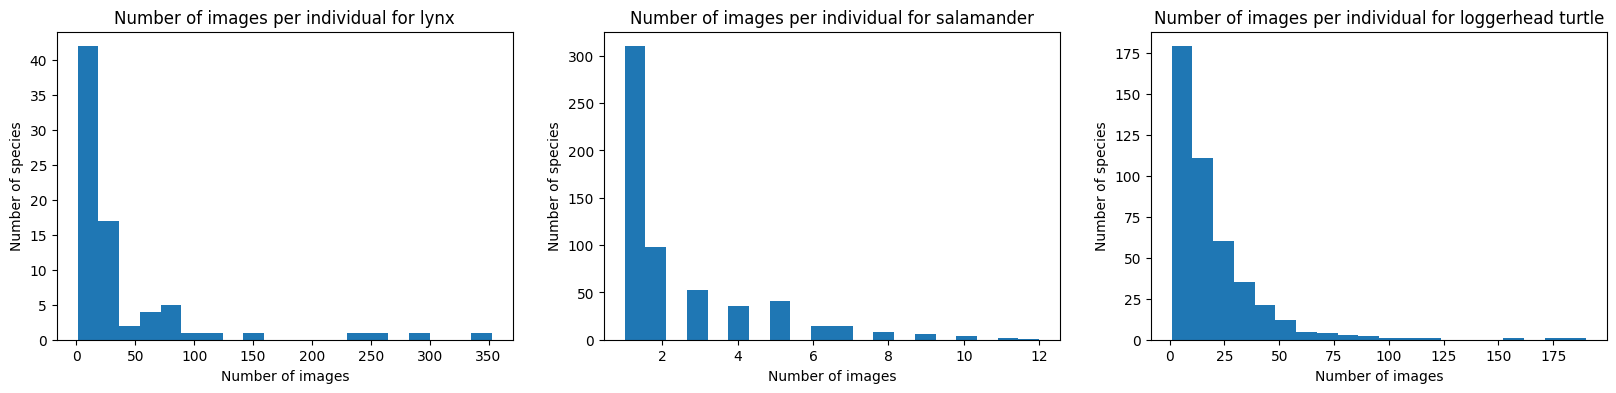

In [8]:
print(f"Number of individuals in database: {dataset_database.metadata['identity'].nunique()}")
fig, axes = plt.subplots(1, 3, figsize=(20, 4))
i = 0
for species in dataset.metadata['species'].unique():
    if pd.notna(species):
        idx = dataset.metadata['species'].str.contains(species)
        idx[idx.isnull()] = False
        axes[i].hist(dataset.metadata['identity'][idx].value_counts(), bins=20)
        axes[i].set_title('Number of images per individual for ' + species)
        axes[i].set_xlabel('Number of images')
        axes[i].set_ylabel('Number of species')
        i += 1
        print(f"Number of individuals for {species}: {dataset.metadata['identity'][idx].nunique()}")
plt.show()